In [42]:
import numpy as np
from tqdm import tqdm, trange
from scipy.sparse import coo_matrix, hstack,vstack
from scipy.interpolate import griddata

from scipy.optimize import fsolve
from scipy import integrate
import sympy as sp

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import random
import time
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import deepxde as dde
from timeit import default_timer
import datetime
import os


In [ ]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/bel fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

plt.rcParams.update(tex_fonts)

def solveBetaFunction(x, gamma, amp, callback1, callback2):
    beta = np.zeros(len(x))
    for idx, val in enumerate(x):
        beta[idx] = amp*callback1(gamma*callback2(val))
    return beta

def tauFunc(gamma, amp, val):
    return amp * np.cos( gamma * np.arccos(val)) + 3

def add_gaussian_noise(x, std_ratio):
    x = np.array(x)
    std = std_ratio * (np.max(x) - np.min(x))
    noise = noise = np.random.normal(0, std, size=x.shape)
    clip_value = std
    noise = np.clip(noise, -clip_value / 2, clip_value / 2)
    return noise

def fFunc(x, y):
    return 5 * np.cos(2 * np.pi * x) + 5 * np.sin(2 * np.pi * y) 

def buildF(x):
    s_cood, q_cood = np.meshgrid(x, x, indexing="ij")
    return fFunc(s_cood, q_cood)


def get_cof_equ_K_19(i, N1, f1_m, hx, a):
    num = N1 - i - 2
    coff = f1_m[i, i+1:N1-1].T
    cofi1 = coo_matrix((2 * np.ones(num), (range(num), range(num))), shape = (num, num)).tocsr()
    cofi1 = cofi1 + coo_matrix((-1 * np.ones((num - 1)), (range(num - 1),range(1, num))),shape = (num, num)).tocsr()
    cofi3_1 = np.tril(np.ones((num, num))) - np.diag(1 / 2 * np.ones(num))
    cofi3_1 = hx * cofi3_1
    cofi3_2 = np.zeros((num,num))
    for k in range(num):
        cofi3_2[k, 0:k] = f1_m[i + 1: i + k + 1, i + k + 1].T
    cofi3 = -hx / (a) * cofi3_1 * cofi3_2
    cofi = cofi1 + coo_matrix(cofi3).tocsr() 
    return cofi, coff

def KernelCalc2(a , hx, f1_m): 
    fii = np.diag(f1_m)
    cofmed = np.zeros((N1, N1))
    cofmed[:, -1] = 1/ 2 * np.ones((1, N1))
    cof_int_zeta_1 = hx * (np.triu(np.ones((N1, N1))) - cofmed - np.diag(1 / 2 * np.ones(N1)))
    K_ii = -1 / a * np.dot(cof_int_zeta_1, fii)
    K = np.diag(K_ii)

    for i in range(N1 - 3, -1, -1 ):
        [cofi, coff] = get_cof_equ_K_19(i,N1,f1_m,hx,a)
        Kibud = K[i, i] * hx * hx / (2 * a) - hx / a
        Ki = np.linalg.solve(cofi.toarray(), K[i+1,i+1:N1-1].T) + np.linalg.solve(cofi.toarray(), np.dot(Kibud, coff))
        K[i, i+1:N1-1]=Ki.T  
    Kbud = K[0, :]
    return K, Kbud 

def get_cof_1(ht,hx,N,a,f_m1,c,tau):#计算状态迭代的矩阵A
    N1=N+1
    cof_int_zeta_1_Nplus1 = get_cof_int_zeta_1(N1,hx)
    cof_int_zeta_1 = cof_int_zeta_1_Nplus1 
    cof_int_zeta_1[0, :] = 0
    C1 = a * ht / hx
    Nsquare = (N1) * N
    At1 = coo_matrix(((1-C1) * np.ones(N), (range(1, N1), range(1, N1))),shape = (N1, N1)).tocsr()
    At1 = At1 + coo_matrix((C1 * np.ones(N), (range(1, N1), range(N1-1))),shape = (N1, N1)).tocsr()
    At1 = At1 + ht * coo_matrix(cof_int_zeta_1 * f_m1).tocsr()

    At2 = coo_matrix((N1,Nsquare)).tocsr()
    At2 = At2 + coo_matrix((c[1 : N+1] * ht, (range(1, N1), range(N, N * (N + 1), N))), shape = (N1, Nsquare)).tocsr()
    tauuu = (np.array(tau) * np.ones((N,N+1))).reshape((-1, 1), order = "f")

    ee = ht / (hx * tauuu)
    diag_vale_c = (1 - ee).squeeze()
    diag_vale_l = ee.squeeze()
    diag_vale_l[N - 1 : Nsquare : N] = 0
    diag_vale_l = np.delete(diag_vale_l, -1)

    At4 = coo_matrix((diag_vale_c, (range(Nsquare), range(Nsquare))), shape = (Nsquare,Nsquare)).tocsr()
    At4 = At4 + coo_matrix((diag_vale_l, (range(Nsquare - 1), range(1, Nsquare))),shape = (Nsquare, Nsquare)).tocsr()

    eee = ee[0 : Nsquare : N].squeeze()

    At3 = coo_matrix((eee, (range(N - 1, Nsquare, N), N1 * [N])), shape = (Nsquare, N1)).tocsr()
    Aa1 = vstack((At1, At3))
    Aa2 = vstack((At2, At4))

    return hstack((Aa1, Aa2))

def datasetGenerate(num, num2, nx, spatial, finalTime, tTotal):
    inputArr1 = []
    output_arr = []
    coe_m = coefficient_matrix(nx)
    ht = finalTime / (tTotal - 1)
    sunNum = tTotal * num * num2
    pbar = tqdm(total=sunNum)
    for i in range(num):
        gamma_tau = np.random.uniform(0, 8)
        amp_tau = np.random.uniform(-1, 1)
        tauTemp = tauFunc(gamma_tau, amp_tau, spatial)

        A2 = get_cof_1(ht, dx, N, a, f1_m, c1, tauTemp)
        for j in range(num2):
            if j > (num2 / 2):               
                gamma = np.random.uniform(0, 8)
                amp = np.random.uniform(0.5, 8)
            else:
                gamma = np.random.uniform(0, 4)
                amp = np.random.uniform(0.5, 4)  

            xuSpace = np.zeros((nx ** 2, tTotal))
            
            bias = np.random.uniform(0, 0.5) 
            xuSpace[:nx, 0] = amp * np.cos(gamma * np.arccos(spatial - bias))  

            for tIndex in range(tTotal-1):
                tIndex1 = tIndex + 1
                xuSpace[:, tIndex1] = A2 @ xuSpace[:, tIndex] 
                pbar.update(1)
            
                uuTemp = xuSpace[nx:, tIndex].reshape((N, N1), order = "f").T
                uuTemp = np.hstack((uuTemp, xuSpace[N, tIndex] * np.ones((N1,1))))
                xuTemp = xuSpace[:nx, tIndex]
                U = solve_contrl_U(uuTemp, tauTemp, Kbud, xuTemp, coe_m)
                
                xuSpace[0, tIndex1] = U
                temp1 = np.tile(tauTemp, (nx, 1))
                temp2 = np.tile(xuTemp, (nx, 1))
                temp3 = np.array([uuTemp, temp1, temp2])
                inputArr1.append(temp3.flatten())
                output_arr.append(U)
                
    pbar.close()
    np.savetxt("../dataset/input95.dat", inputArr1)
    np.savetxt("../dataset/output95.dat", output_arr)
    return 


def coefficient_matrix(length):
    obj_matrix = np.triu(np.ones((length, length))) - np.diag(0.5 * np.ones(length))
    obj_matrix[0, :] = 1 / 2
    obj_matrix[:, -1] = 1 / 2
    return obj_matrix * dx * dx

def solve_contrl_U(uu, tau, Kbud, xu, coe_m):
    u1_temp_y = spatial / (a * tau)
    u1_x, u1_y = np.meshgrid(spatial, u1_temp_y)

    u2_temp_y = spatial / (a * tau)
    u2_x, u2_y = np.meshgrid(spatial, u2_temp_y)
    
    x_star = np.hstack((zeta1_m.flatten()[:,None], eta1_m.flatten()[:,None]))


    u1 = np.diag(griddata(x_star, uu.ravel(), (u1_x, u1_y), method="cubic", fill_value = 0))
    u2 = griddata(x_star, uu.ravel(), (u2_x, u2_y), method="cubic", fill_value = 0)  

    contrl1 = np.trapz( Kbud * xu, dx = dx)
    contrl2 = np.trapz(c1 * u1 / a, dx = dx)

    c_m = np.tile(c1, (nx, 1))
    contrl3 = np.sum(c_m * K * u2 * coe_m)
    U = contrl1 - contrl2 + contrl3
    return U

def count_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

def get_cof_int_zeta_1(N,hx):
    cofmed = np.zeros((N,N))
    cofmed[:, N - 1] = 1 / 2 * np.ones((1,N))
    cof_int_zeta_1 = hx * (np.triu(np.ones((N,N))) - cofmed - np.diag(1 / 2 * np.ones(N)))
    return cof_int_zeta_1


In [44]:
a = 1
X = 1
dx = 1 / 20
nx = int(round(X/dx))+1
spatial = np.linspace(0, X, nx, dtype=np.float32)
N1 = len(spatial)
N = N1 - 1                  
# Parameters of NN
epochs =300
ntrain = 900
ntest = 100

gamma = 0.5
learning_rate = 0.00001
step_size= 40
modes=12
width=32
batch_size = 50

c1 = 20 - 20 * spatial
[eta1_m, zeta1_m]= np.meshgrid(spatial,spatial)


In [45]:

f1_m = buildF(spatial)
fii = np.diag(f1_m)

K, Kbud =  KernelCalc2(1, dx, f1_m)
KT = K.T
timeTest = 10
pointTest = 401
recount = True

In [46]:
if recount == True:
    datasetGenerate(30, 20, nx, spatial, timeTest, pointTest)
    print("Date is ", datetime.datetime.now())

100%|█████████▉| 240000/240600 [18:02<00:02, 221.62it/s]


Date is  2024-10-30 19:30:25.838275


In [ ]:
sub_xy =  1
inpArr1 = np.loadtxt("../dataset/input95.dat", dtype=np.float32)
outArr = np.loadtxt("../dataset/output95.dat", dtype=np.float32)


xxx = inpArr1[::sub_xy, :]
yyy = outArr[::sub_xy]



x_train, x_test, y_train, y_test = train_test_split(xxx, yyy, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))


In [48]:
grids = []
grids.append(np.linspace(0, 1, nx, dtype=np.float32))
grids.append(spatial * spatial)
grid2 = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T  
grid2 = torch.from_numpy(grid2).cuda()
class BranchNet(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape
        self.conv1 = torch.nn.Conv2d(3, 64, 5, stride=2)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(64, 128, 5, stride=2)
        self.fc1 = torch.nn.Linear(1152, 256)

        
    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], 3, self.shape, self.shape))
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)    
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        return x
    
class DeepONetModified(nn.Module):
    def __init__(self, m2, branch_2dim, dim_x, projection):#project=1
        super(DeepONetModified, self).__init__()
        self.net1 = dde.nn.DeepONetCartesianProd([m2, branch_2dim], [dim_x, 64 ,128, 256, 256], "relu", "Glorot normal").cuda()
        self.fc3 = torch.nn.Linear(441, 256)
        self.relu = torch.nn.ReLU()
        self.fc4 = torch.nn.Linear(256, 128)
        self.fc5 = torch.nn.Linear(128, projection)
        

    def forward(self, x):
        x, grid = x[0], x[1]
        x = self.net1((x, grid))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        return self.fc5(x)



m2 = nx * nx
projection = 1
model = DeepONetModified(m2, BranchNet(nx),  2, projection).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

#loss = torch.nn.MSELoss()
loss = torch.nn.SmoothL1Loss(reduction='mean', beta=1.0)
train_lossArr = []
test_lossArr = []
time_Arr = []


In [49]:
print("strat to train~~")
for ep in trange(epochs):
    t1 = default_timer()
    model.train()
    t1 = default_timer()
    train_loss = 0
    for xxTemp, yyTemp in trainData:
        xx, y1 = xxTemp.cuda(), yyTemp.cuda()
        optimizer.zero_grad()

        out = model((xx, grid2))
        lp = loss(out.view(batch_size, -1), y1.view(batch_size, -1))
        lp.backward()
        
        optimizer.step()
        train_loss += lp.item()
        
    scheduler.step()

    model.eval()
    test_loss = 0
    with torch.no_grad():#测试集
        for xxTemp, yyTemp in testData:
            xx, y1 = xxTemp.cuda(), yyTemp.cuda()
            out = model((xx, grid2))
            test_loss += loss(out.view(batch_size, -1), y1.view(batch_size, -1)).item()

            
    train_loss /= len(trainData)
    test_loss /= len(testData)
    
    train_lossArr.append(train_loss)
    test_lossArr.append(test_loss)
    
    t2 = default_timer()
    time_Arr.append(t2-t1)
    if ep%50 == 0:
        print(ep, t2-t1, train_loss, test_loss)


print("end")

torch.save(model.state_dict(), "../module/modedlNet95.pt")


strat to train~~


0 8.663476945948787 0.03841856396961871 0.0029821065425494455


50 8.877352567040361 7.129452365922538e-05 4.289450117103873e-05


100 8.772236909950152 3.789803298106849e-05 4.088305177371391e-05


150 8.76340887194965 2.8138301190107608e-05 2.5385640638830866e-05


200 9.166784284985624 2.182531792295587e-05 2.1790521779034103e-05


250 8.568387415027246 2.0594784237723027e-05 1.864058222906806e-05


100%|██████████| 300/300 [44:00<00:00,  8.80s/it]

end


<Figure size 800x600 with 0 Axes>

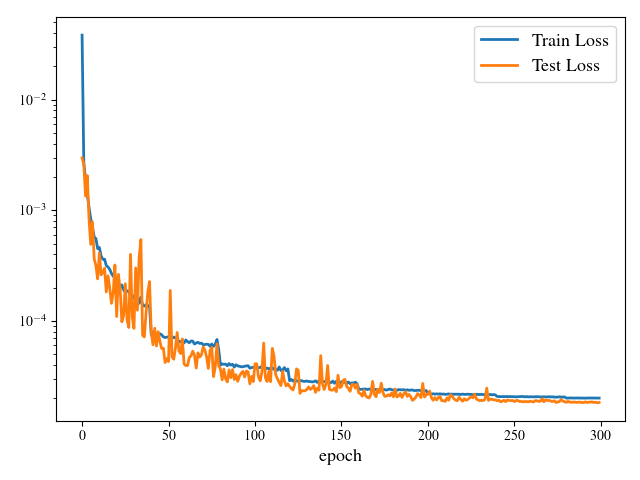

In [50]:
my_dpi = 600
fig = plt.figure(figsize=(800 / my_dpi, 600 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False
flg, ax = plt.subplots()
ax.plot(train_lossArr, label="Train Loss", linewidth=2)
ax.plot(test_lossArr, label="Test Loss", linewidth=2)

plt.xlabel('epoch',fontsize="13")
plt.tick_params(labelsize=10)
fig = plt.gcf()
fig.tight_layout()
plt.legend(fontsize="13", loc="best")
plt.yscale("log")
#plt.ylim(1e-7, 1e-1)
#plt.savefig('../picture2/9_25/trainLoss.jpg', dpi=500,bbox_inches='tight')
plt.show()



In [51]:

model2 = DeepONetModified(m2, BranchNet(nx),  2, projection).cpu()
if os.path.exists("/home/lab422/422File/Class_2022/humjacky/Tau2/module/modedlNet95.pt"):
    model2.load_state_dict(torch.load("/home/lab422/422File/Class_2022/humjacky/Tau2/module/modedlNet95.pt", map_location = 'cpu'))
    print("model on device：", next(model2.parameters()).device)
    print("success！")
    
girdEstimate = grid2.cpu()


model on device： cpu
success！


In [52]:
final_time = 20

ht = timeTest / (pointTest - 1)
Maxstep = int(final_time / ht)
time = np.linspace(0, final_time, Maxstep + 1) 
gammaTau = 5
ampTau = 0.5
tauTrue = tauFunc(gammaTau, ampTau, spatial)


coe_m = coefficient_matrix(nx)

A = get_cof_1(ht, dx, N, a, f1_m, c1, tauTrue)

In [53]:

x_u = np.zeros((N1 ** 2, Maxstep + 1))
xx = 3 * np.cos(4 * np.arccos(spatial - 0.3))
uu = np.zeros((N * N1, 1)).squeeze()
x_u[:, 0] = np.hstack((xx, uu))
xx_uu = x_u[:, 0]

UCalc = np.zeros(Maxstep)
UEstimate = np.zeros(Maxstep)
UEstimate2 = np.zeros(Maxstep)
lossU = np.zeros(Maxstep, dtype=np.float16)
#NO controller
for tt in trange(Maxstep):
    uu_temps1 = np.around(xx_uu[N1 : ].reshape((N, N1), order = "f"), 9).T
    uu_temps1 = np.hstack((uu_temps1, xx_uu[N1 - 1] * np.ones((N+1,1)))) 
    
    with torch.no_grad():
        TauArray = np.tile(tauTrue, (nx, 1))
        xArray = np.tile(xx_uu[:N1], (nx, 1))
        Input = np.array([uu_temps1, TauArray, xArray], dtype=np.float32).flatten()
        Input = torch.from_numpy(np.expand_dims(Input, 0)).cpu()
        UEstimate[tt] = model2((Input, girdEstimate))
    
    xx_uu = A @ x_u[:, tt]  
    xx_uu[0] = UEstimate[tt]
    
    x_u[:, tt+1] = xx_uu  
X = x_u[0 : N1, :]

100%|██████████| 800/800 [00:29<00:00, 27.11it/s]


In [54]:

x_u2 = np.zeros((N1 ** 2, Maxstep + 1))
xx2 = xx


uu2 = np.zeros((N * N1, 1)).squeeze()
x_u2[:, 0] = np.hstack((xx2, uu2))
xx_uu2 = x_u2[:, 0]
    
#numberical controller
for tt in trange(Maxstep):
    uu_temps2 = np.around(xx_uu2[N1 : ].reshape((N, N1), order = "f"), 5).T
    uu_temps2 = np.hstack((uu_temps2, xx_uu2[N1 - 1] * np.ones((N+1,1)))) 
    UCalc[tt] = solve_contrl_U(uu_temps2, tauTrue, Kbud, xx_uu2[: N1], coe_m)    
    xx_uu2 = A @ x_u2[:, tt]  
    
    xx_uu2[0] = UCalc[tt]

    x_u2[:, tt+1] = xx_uu2
X2 = x_u2[0 : N1, :]

100%|██████████| 800/800 [00:03<00:00, 215.54it/s]


0.0


<Figure size 800x800 with 0 Axes>

<Figure size 640x480 with 0 Axes>

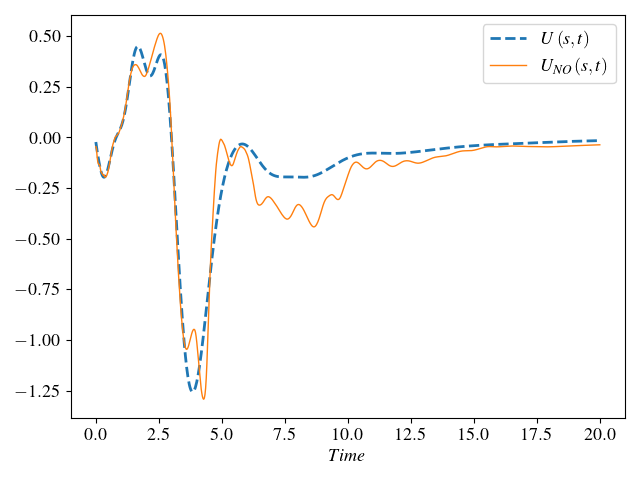

In [55]:
my_dpi = 300
fig_intep=plt.figure(figsize=(800 / my_dpi, 800 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  
fig = plt.figure()
flg, ax = plt.subplots()
time2 = np.linspace(0, final_time, Maxstep)
ax.plot(time2, UCalc, label= r'$U\left(s,t\right)$',linestyle='--', linewidth=2)
ax.plot(time2, UEstimate, label=r'$U_{NO}\left(s,t\right)$', linewidth=1)


plt.xlabel(r'$Time$',fontsize="13")
plt.tick_params(labelsize=13)
fig = plt.gcf()
fig.tight_layout()
plt.legend(loc="best",fontsize="13")
plt.savefig('../picture2/9_25/Compare.jpg', dpi=300,bbox_inches='tight')
print(np.abs(lossU[-1]))


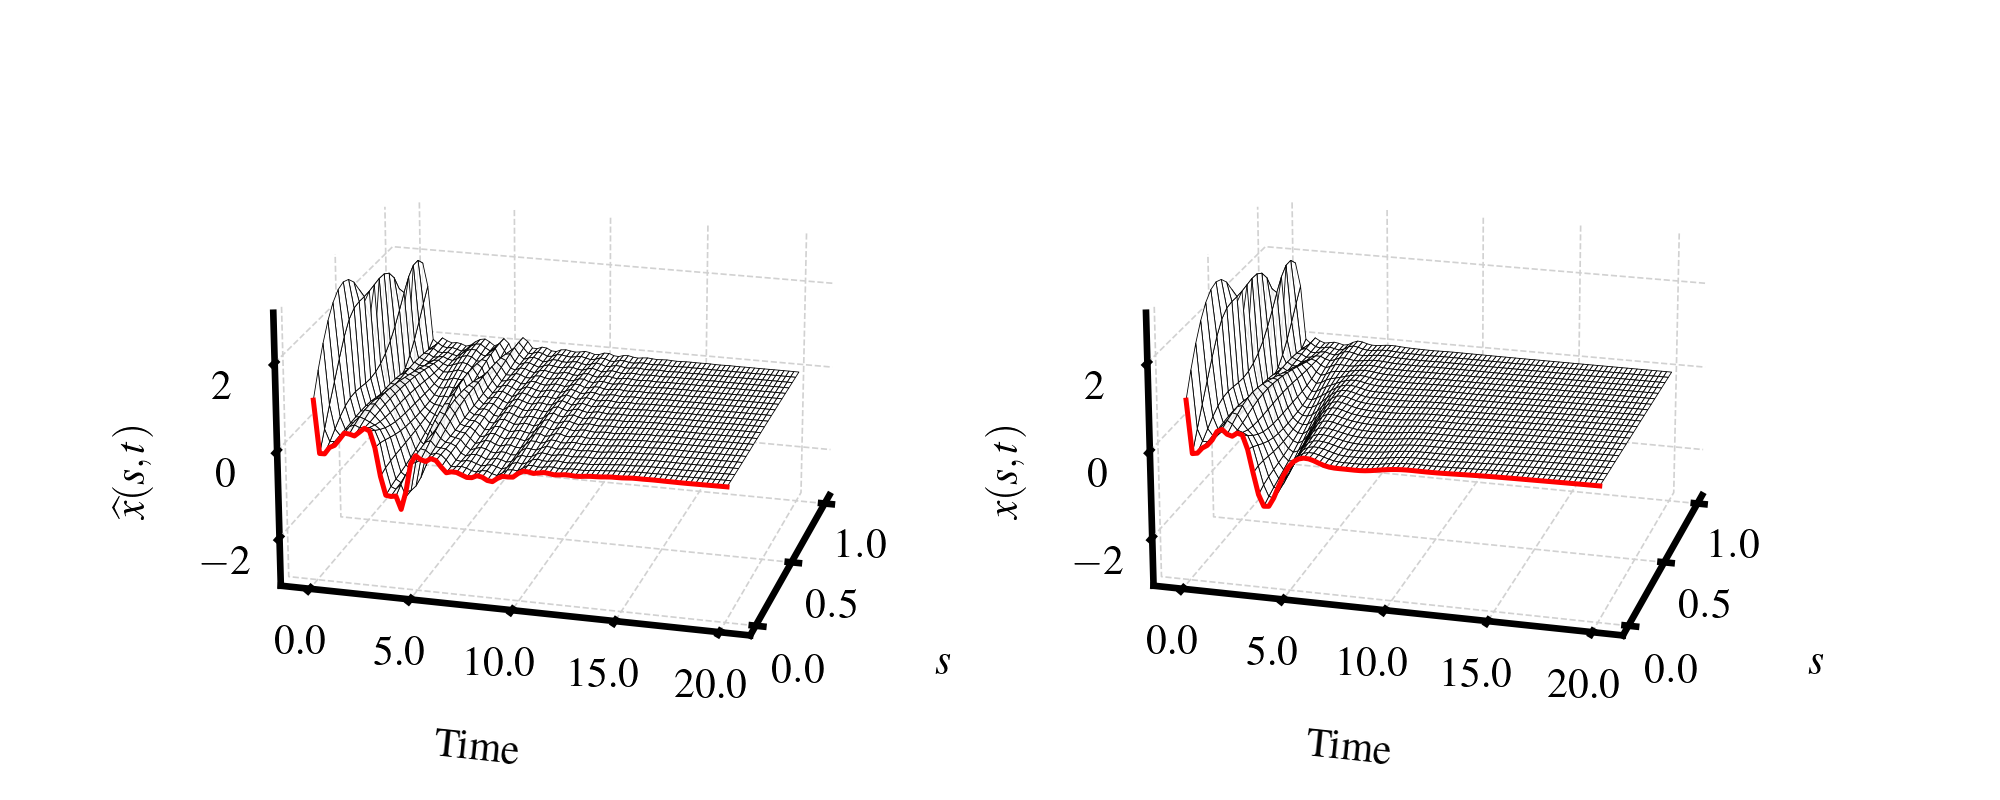

In [56]:
############### draw output
my_dpi=300
# res = 10
draw_rate = 10
nt_draw = Maxstep + 1
temporal_draw=time[0:nt_draw:draw_rate]
meshx2, mesht2 = np.meshgrid(spatial, temporal_draw, indexing="ij")
test=np.zeros(len(temporal_draw))
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

fig = plt.figure(figsize=(1000 / my_dpi, 400 / my_dpi), dpi=600)
subfig = fig.subfigures(nrows=1, ncols=1, hspace=0)
subfig.subplots_adjust(left=0.1, bottom=0, right=0.9, top=0.99, wspace=0.2, hspace=0)
ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    

ax[0].plot_surface(meshx2, mesht2, X[0:nx, 0:nt_draw:draw_rate], edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)

ax[0].plot(test, temporal_draw, X[0, 0:nt_draw:draw_rate], color="red", lw=0.6, antialiased=True)

ax[0].invert_xaxis()
ax[0].get_proj = lambda: np.dot(Axes3D.get_proj(ax[0]), np.diag([0.8, 1, 0.8, 1]))

ax[0].view_init(20,15)
ax[0].set_xlabel(r"$s$",fontsize = 5 , labelpad=-6)
ax[0].set_ylabel(r"$\rm{Time}$",fontsize = 5 , labelpad=-6)
ax[0].set_zlabel(r"$\widehat{x}(s,t)$",fontsize = 5 , rotation = 90, labelpad=-10)
ax[0].set_xticks([0, 0.5, 1])

ax[0].zaxis.set_rotate_label(False)
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[0].tick_params(axis='both', labelsize=5 , pad=-4) 


######################################################


ax[1].plot_surface(meshx2, mesht2, X2[0:nx, 0:nt_draw:draw_rate], edgecolor="black",lw=0.1, 
                        color="white", shade=False, rasterized=True,alpha=0.9,antialiased=True, rstride=1, cstride=1)

ax[1].plot(test, temporal_draw, X2[0, 0:nt_draw:draw_rate], color="red", lw=0.6, antialiased=True)
ax[1].invert_xaxis()
 
ax[1].get_proj = lambda: np.dot(Axes3D.get_proj(ax[1]), np.diag([0.8, 1, 0.8, 1]))

ax[1].view_init(20, 15)
ax[1].set_xlabel(r"$s$",fontsize = 5 , labelpad=-6)
ax[1].set_ylabel(r"$\rm{Time}$",fontsize = 5 , labelpad=-6)
ax[1].set_zlabel(r"$x(s,t)$", fontsize = 5 ,rotation = 90, labelpad=-10)
ax[1].zaxis.set_rotate_label(False)
ax[1].set_xticks([0, 0.5, 1])

ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
tmp_planes = ax[0].zaxis._PLANES 
ax[0].zaxis._PLANES = ( tmp_planes[3], tmp_planes[2], 
                     tmp_planes[1], tmp_planes[0], 
                     tmp_planes[4], tmp_planes[5])
tmp_planes = ax[1].zaxis._PLANES
ax[1].zaxis._PLANES = ( tmp_planes[3], tmp_planes[2], 
                     tmp_planes[1], tmp_planes[0], 
                     tmp_planes[4], tmp_planes[5]) 
ax[1].tick_params(axis='both', labelsize=5, pad=-4 ) 
plt.savefig('../picture2/9_25/x_state.jpg', dpi=600)#,bbox_inches='tight'


<Figure size 800x600 with 0 Axes>

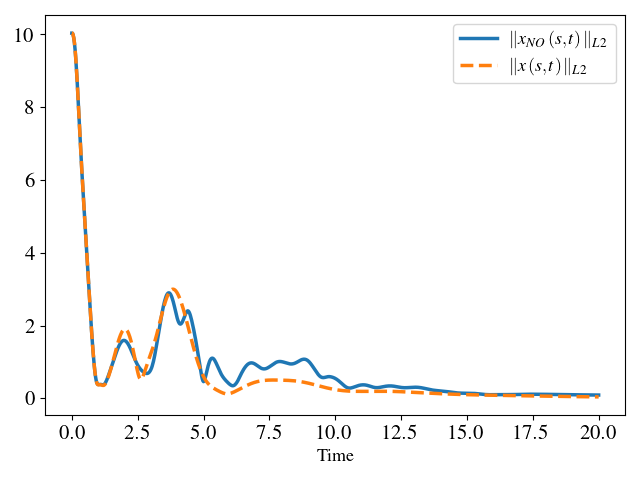

In [57]:
my_dpi = 300
interL = np.linalg.norm(X, axis =0)
interL2 = np.linalg.norm(X2, axis =0)
fig = plt.figure(figsize=(800 / my_dpi, 600 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False  
flg, ax = plt.subplots()
time2 = np.linspace(0, final_time, Maxstep+1)
ax.plot(time2, interL, label=r"$\Vert x_{NO}\left(s,t \right) \Vert  _{L2}$", linewidth=2.5)
ax.plot(time2, interL2, label=r"$\Vert x\left(s,t \right) \Vert  _{L2}$",linestyle='--', linewidth=2.5)
#$'r'$\lVert x\left( \zeta ,t \right) \rVert _{L2}$'
plt.xlabel("Time",fontsize="13")
plt.tick_params(labelsize=15)
fig = plt.gcf()
fig.tight_layout()
plt.legend(fontsize="13", loc="best")
plt.savefig('../picture2/9_25/L2.jpg', dpi=300,bbox_inches='tight')
plt.show()


<Figure size 800x600 with 0 Axes>

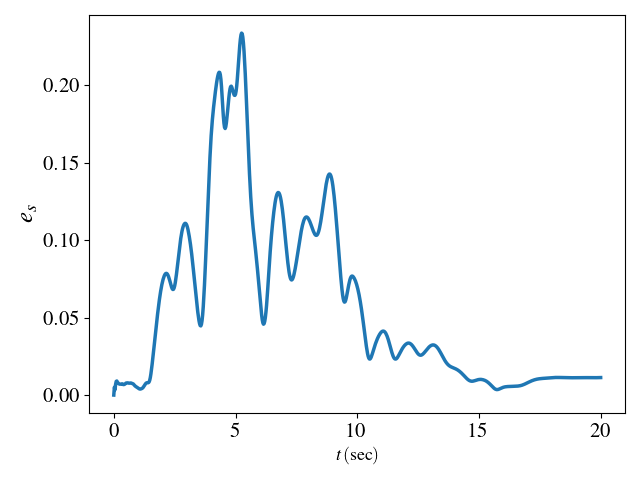

0.0113008972534781


In [58]:
my_dpi = 300
temp = np.sum((X - X2) * (X - X2) * dx, axis=0)
L2Norm = np.sqrt(temp)

fig = plt.figure(figsize=(800 / my_dpi, 600 / my_dpi), dpi=my_dpi)
plt.rcParams['axes.unicode_minus'] = False 
flg, ax = plt.subplots()
time2 = np.linspace(0, final_time, Maxstep+1)
ax.plot(time2, L2Norm, linewidth=2.5)
plt.xlabel(r'$t(\mathrm{sec})$',fontsize="13")
plt.ylabel(r'$e_s$',fontsize="18")
plt.tick_params(labelsize=15)
fig = plt.gcf()
fig.tight_layout()
plt.savefig('../picture2/9_25/L2Norm.jpg', dpi=300,bbox_inches='tight')
plt.show()
print(L2Norm[-1])